In [1]:
from torch import Tensor, nn

from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from tqdm.auto import tqdm
from transformer_lens import ActivationCache, HookedTransformer, utils
from transformer_lens.hook_points import HookPoint
from tqdm import tqdm
import numpy as np
import pandas as pd
import gc
import requests
import os
import sys
import json
from salmon.triplets.offline import OfflineEmbedding
from sklearn.model_selection import train_test_split

2025-08-26 12:22:05.920808: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-26 12:22:05.941254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756228925.963112 2304075 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756228925.969670 2304075 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756228925.987847 2304075 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [14]:
embed_human = pd.read_csv("../data/spose/embeddings_human_out.csv")

embed_d5 = pd.read_csv("embeddings_gemma-3-12b-it_d5.csv")
embed_d10 = pd.read_csv("embeddings_gemma-3-12b-it_d10.csv")
embed_d15 = pd.read_csv("embeddings_gemma-3-12b-it_d15.csv")
embed_d20 = pd.read_csv("embeddings_gemma-3-12b-it_d20.csv")

In [15]:
embed_d5.head()

item  id     dim_0     dim_1     dim_2     dim_3     dim_4
0         airbag   0 -0.218213 -0.464719 -0.483144 -0.312118  0.229412
1          album   1  0.236843 -0.222890  0.108011  0.144619  0.064369
2      appetizer   2  0.242218  0.488744  0.388116  0.461069  0.449520
3     applesauce   3  0.070254  0.335248  0.394969  0.307296  0.466440
4  backscratcher   4 -0.135636 -0.194294  0.036139 -0.134115 -0.761152

In [ ]:
import pandas as pd
import numpy as np

# --- 1. Filter to only items also in embed_d5 ---
filtered = embed_human[embed_human["item"].isin(embed_d5["item"])].copy()


embed_split = filtered["embedding"].str.strip().str.split(r"\s+")

# convert list-of-strings to a numpy array of floats
embed_array = np.array(embed_split.tolist(), dtype=float)

embed_df = pd.DataFrame(embed_array, columns=[f"dim_{i}" for i in range(embed_array.shape[1])])

embed_human = pd.concat([filtered[["item"]].reset_index(drop=True), embed_df], axis=1)


In [19]:
embed_human.head()
embed_human.to_csv("embed_human_out.csv")

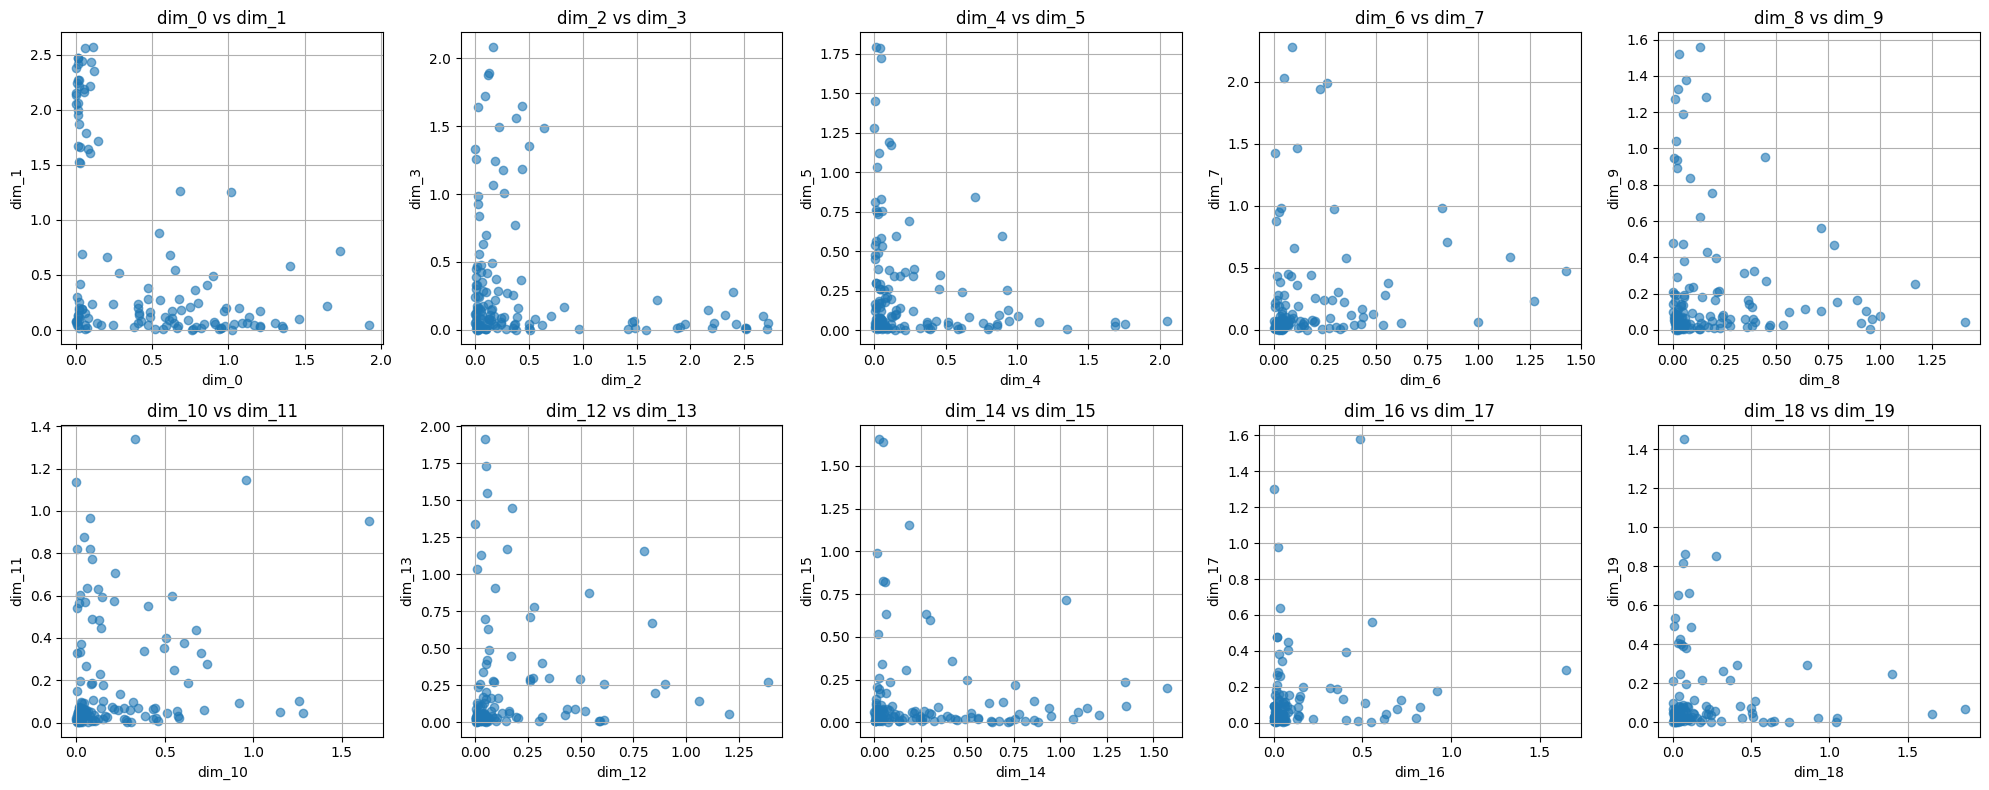

In [23]:
import matplotlib.pyplot as plt

# number of subplots (20 dims → 10 plots)
n_pairs = 10  
dims = [f"dim_{i}" for i in range(20)]

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for idx, ax in enumerate(axes.flat):
    d_x, d_y = dims[2*idx], dims[2*idx + 1]
    ax.scatter(embed_human[d_x], embed_human[d_y], alpha=0.6)
    ax.set_xlabel(d_x)
    ax.set_ylabel(d_y)
    ax.set_title(f"{d_x} vs {d_y}")
    ax.grid(True)

plt.tight_layout()
plt.show()


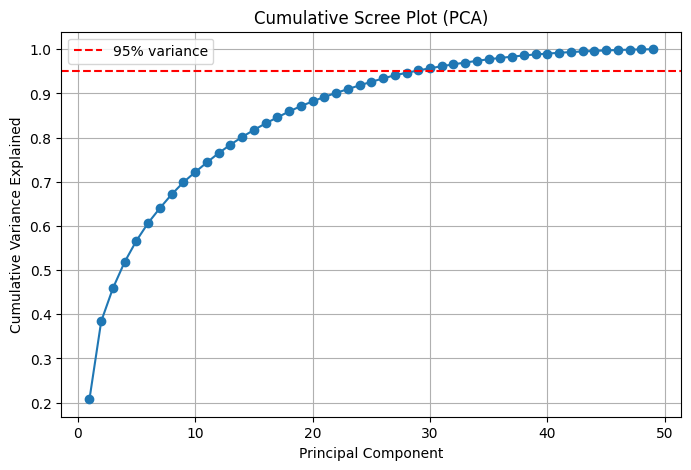

In [26]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- Extract embeddings matrix ---
X = embed_human.filter(like="dim_").values  

# --- PCA ---
pca = PCA()
pca.fit(X)

# --- Cumulative variance ---
cum_var = pca.explained_variance_ratio_.cumsum()

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cum_var) + 1), cum_var, marker="o")
plt.axhline(y=0.95, color="red", linestyle="--", label="95% variance")

plt.xlabel("Principal Component")
plt.ylabel("Cumulative Variance Explained")
plt.title("Cumulative Scree Plot (PCA)")
plt.legend()
plt.grid(True)
plt.show()


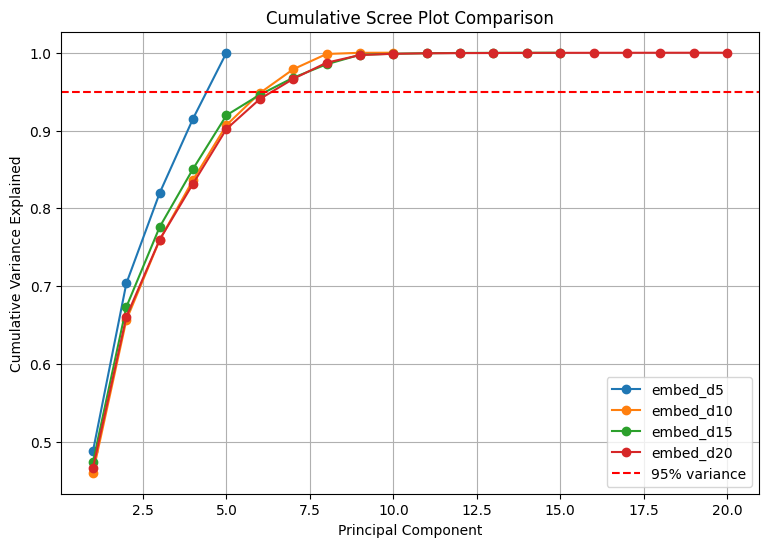

In [29]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def cumulative_var(df):
    X = df.filter(like="dim_").values
    pca = PCA()
    pca.fit(X)
    return pca.explained_variance_ratio_.cumsum()

# compute cumulative variance for each dataset
cum_d5  = cumulative_var(embed_d5)
cum_d10 = cumulative_var(embed_d10)
cum_d15 = cumulative_var(embed_d15)
cum_d20 = cumulative_var(embed_d20)

# plot all on one graph
plt.figure(figsize=(9, 6))
plt.plot(range(1, len(cum_d5)  + 1), cum_d5,  marker="o", label="embed_d5")
plt.plot(range(1, len(cum_d10) + 1), cum_d10, marker="o", label="embed_d10")
plt.plot(range(1, len(cum_d15) + 1), cum_d15, marker="o", label="embed_d15")
plt.plot(range(1, len(cum_d20) + 1), cum_d20, marker="o", label="embed_d20")

# horizontal 95% line
plt.axhline(y=0.95, color="red", linestyle="--", label="95% variance")

plt.xlabel("Principal Component")
plt.ylabel("Cumulative Variance Explained")
plt.title("Cumulative Scree Plot Comparison")
plt.legend()
plt.grid(True)
plt.show()


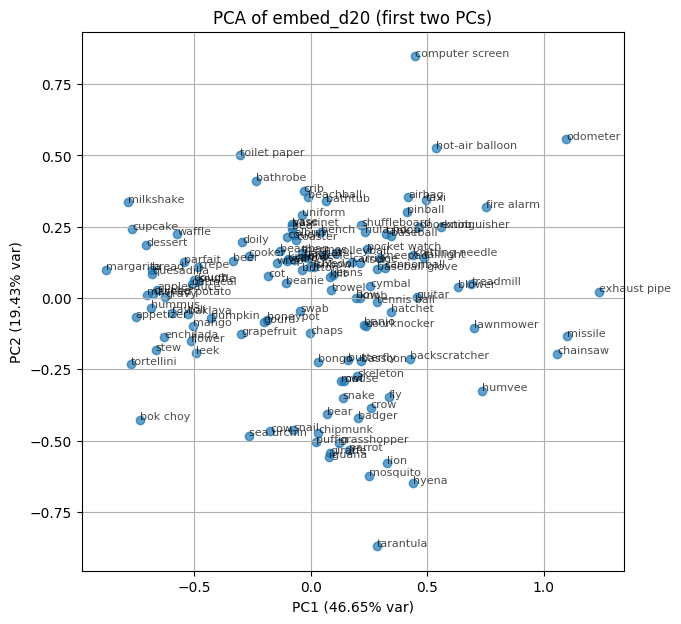

In [30]:
X_d20 = embed_d20.filter(like="dim_").values  

# --- PCA (2 components for plotting) ---
pca_d20 = PCA(n_components=2)
X_d20_pca = pca_d20.fit_transform(X_d20)

# --- Plot ---
plt.figure(figsize=(7, 7))
plt.scatter(X_d20_pca[:, 0], X_d20_pca[:, 1], alpha=0.7)

# annotate with item labels
for i, txt in enumerate(embed_d20["item"]):
    plt.annotate(txt, (X_d20_pca[i, 0], X_d20_pca[i, 1]), fontsize=8, alpha=0.7)

plt.xlabel("PC1 (%.2f%% var)" % (pca_d20.explained_variance_ratio_[0] * 100))
plt.ylabel("PC2 (%.2f%% var)" % (pca_d20.explained_variance_ratio_[1] * 100))
plt.title("PCA of embed_d20 (first two PCs)")
plt.grid(True)
plt.show()

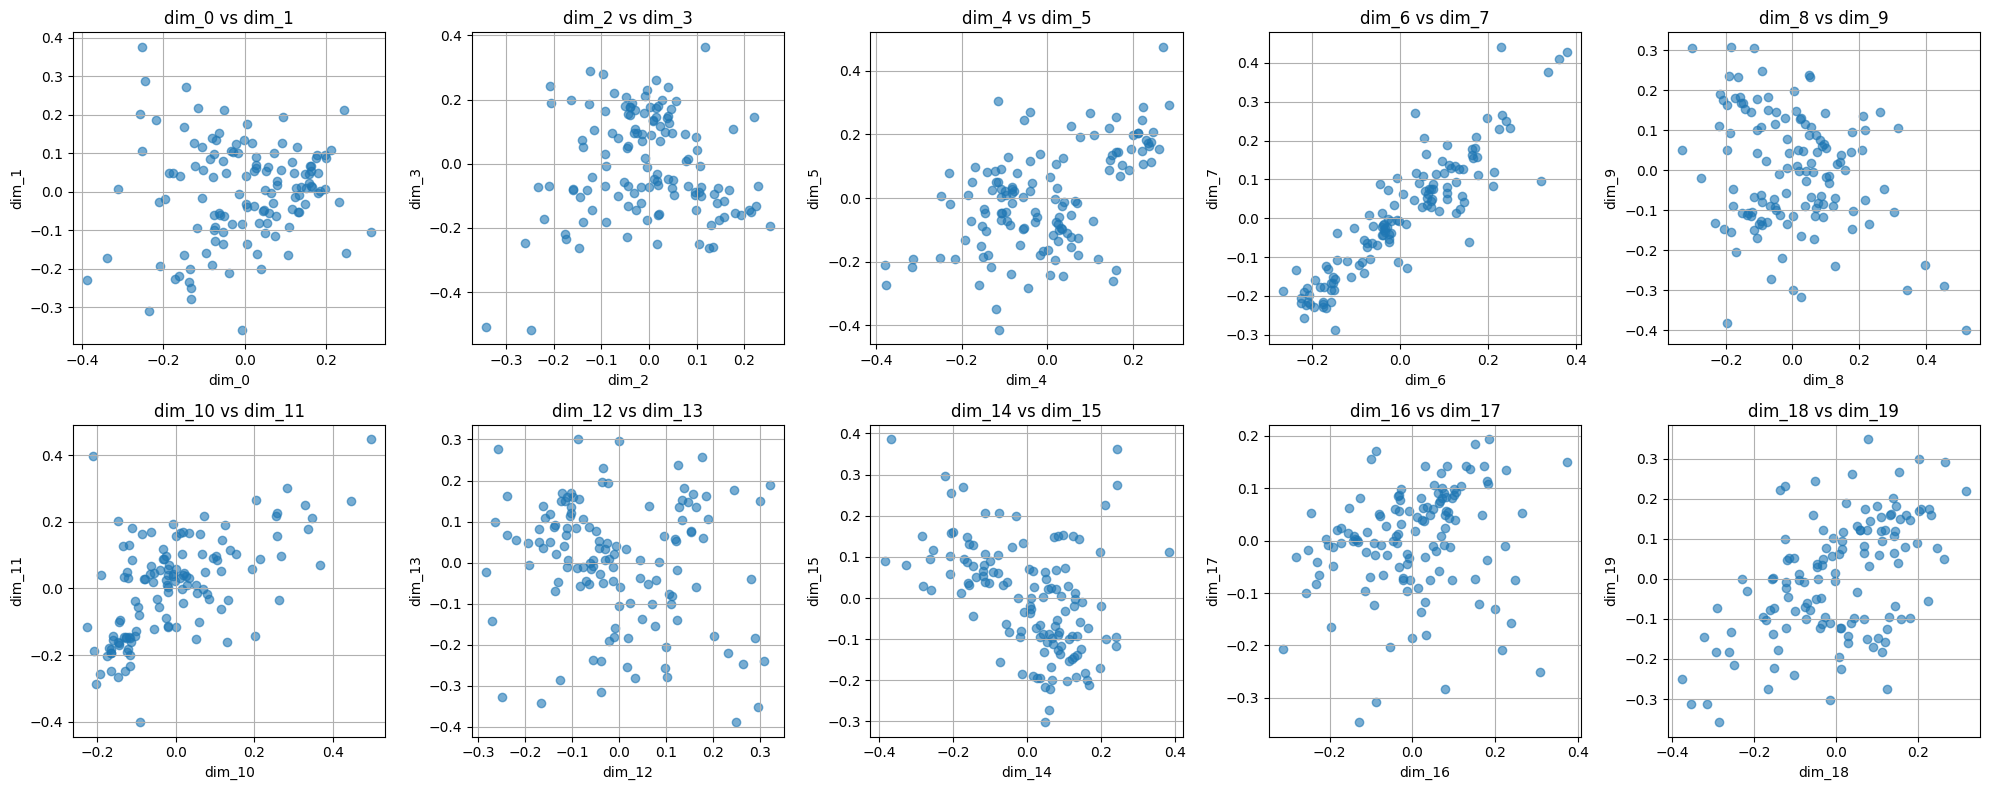

In [31]:
import matplotlib.pyplot as plt

# first 20 dims
dims = [f"dim_{i}" for i in range(20)]
n_pairs = len(dims) // 2  # 10 plots

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for idx, ax in enumerate(axes.flat):
    d_x, d_y = dims[2*idx], dims[2*idx + 1]
    ax.scatter(embed_d20[d_x], embed_d20[d_y], alpha=0.6)
    ax.set_xlabel(d_x)
    ax.set_ylabel(d_y)
    ax.set_title(f"{d_x} vs {d_y}")
    ax.grid(True)

plt.tight_layout()
plt.show()


In [32]:
import numpy as np
from scipy.linalg import orthogonal_procrustes

# --- 1. Align items ---
# keep only rows in human that exist in d20
common = embed_human[embed_human["item"].isin(embed_d20["item"])].copy()
common_d20 = embed_d20[embed_d20["item"].isin(common["item"])].copy()

# make sure same order
common = common.set_index("item").loc[common_d20["item"]].reset_index()

# --- 2. Extract first 20 dims ---
X_human = common.filter(like="dim_").iloc[:, :20].to_numpy()
X_d20   = common_d20.filter(like="dim_").iloc[:, :20].to_numpy()

# --- 3. Orthogonal Procrustes ---
R, scale = orthogonal_procrustes(X_human, X_d20)

# --- 4. Similarity (Procrustes correlation) ---
X_human_aligned = X_human @ R
ssq = np.sum(X_human_aligned**2)
procrustes_r2 = 1 - np.sum((X_human_aligned - X_d20)**2) / ssq

print(f"Procrustes similarity (R²) using first 20 dims: {procrustes_r2:.4f}")


Procrustes similarity (R²) using first 20 dims: 0.2436


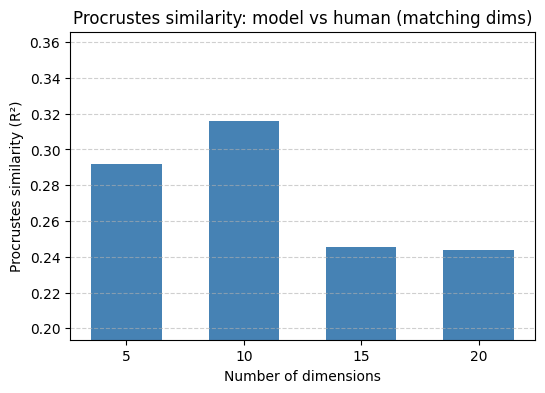

In [39]:
import matplotlib.pyplot as plt

# --- Bar plot ---
dims = list(scores.keys())
vals = list(scores.values())

plt.figure(figsize=(6,4))
plt.bar(dims, vals, width=3, color="steelblue")

plt.xticks(dims, [str(d) for d in dims])  # discrete labels 5,10,15,20
plt.xlabel("Number of dimensions")
plt.ylabel("Procrustes similarity (R²)")
plt.title("Procrustes similarity: model vs human (matching dims)")

# zoom y-axis to range of bars with a bit of padding
ymin, ymax = min(vals), max(vals)
plt.ylim(ymin - 0.05, ymax + 0.05)

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


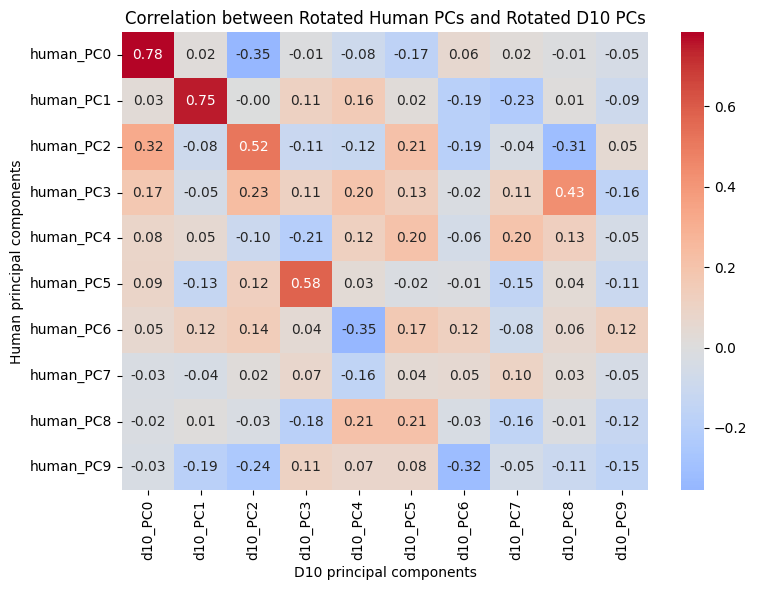

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- Subset first 10 dims ---
H10 = subset_dims(embed_human_common, 10).values
D10 = subset_dims(embed_d10_common, 10).values

# --- Rotate into PCA space (10 PCs) ---
H10_rot = PCA(n_components=10).fit_transform(H10)
D10_rot = PCA(n_components=10).fit_transform(D10)

# --- Compute correlation matrix (human PCs vs d10 PCs) ---
corr_matrix = pd.DataFrame(
    np.corrcoef(H10_rot.T, D10_rot.T)[:10, 10:],  # cross block
    index=[f"human_PC{i}" for i in range(10)],
    columns=[f"d10_PC{j}" for j in range(10)]
)

# --- Plot heatmap ---
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation between Rotated Human PCs and Rotated D10 PCs")
plt.xlabel("D10 principal components")
plt.ylabel("Human principal components")
plt.tight_layout()
plt.show()


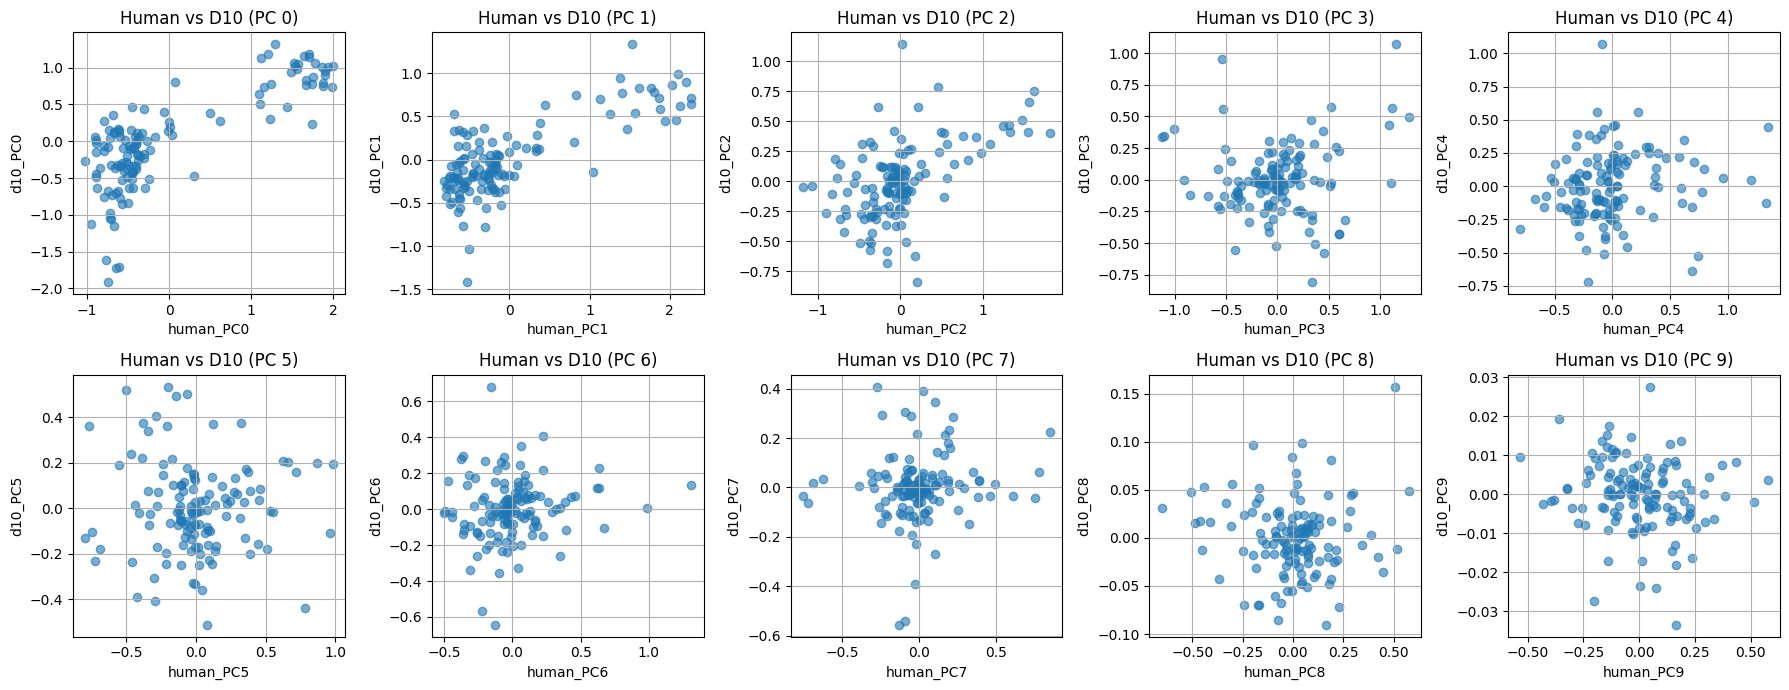

In [45]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- Subset first 10 dims ---
H10_raw = subset_dims(embed_human_common, 10).values
D10_raw = subset_dims(embed_d10_common, 10).values

# --- Rotate into PCA space ---
H10_rot = PCA(n_components=10).fit_transform(H10_raw)
D10_rot = PCA(n_components=10).fit_transform(D10_raw)

# --- Scatterplots PC by PC ---
fig, axes = plt.subplots(2, 5, figsize=(18, 7))

for i, ax in enumerate(axes.flat):
    ax.scatter(H10_rot[:, i], D10_rot[:, i], alpha=0.6)
    ax.set_xlabel(f"human_PC{i}")
    ax.set_ylabel(f"d10_PC{i}")
    ax.set_title(f"Human vs D10 (PC {i})")
    ax.grid(True)

plt.tight_layout()
plt.show()


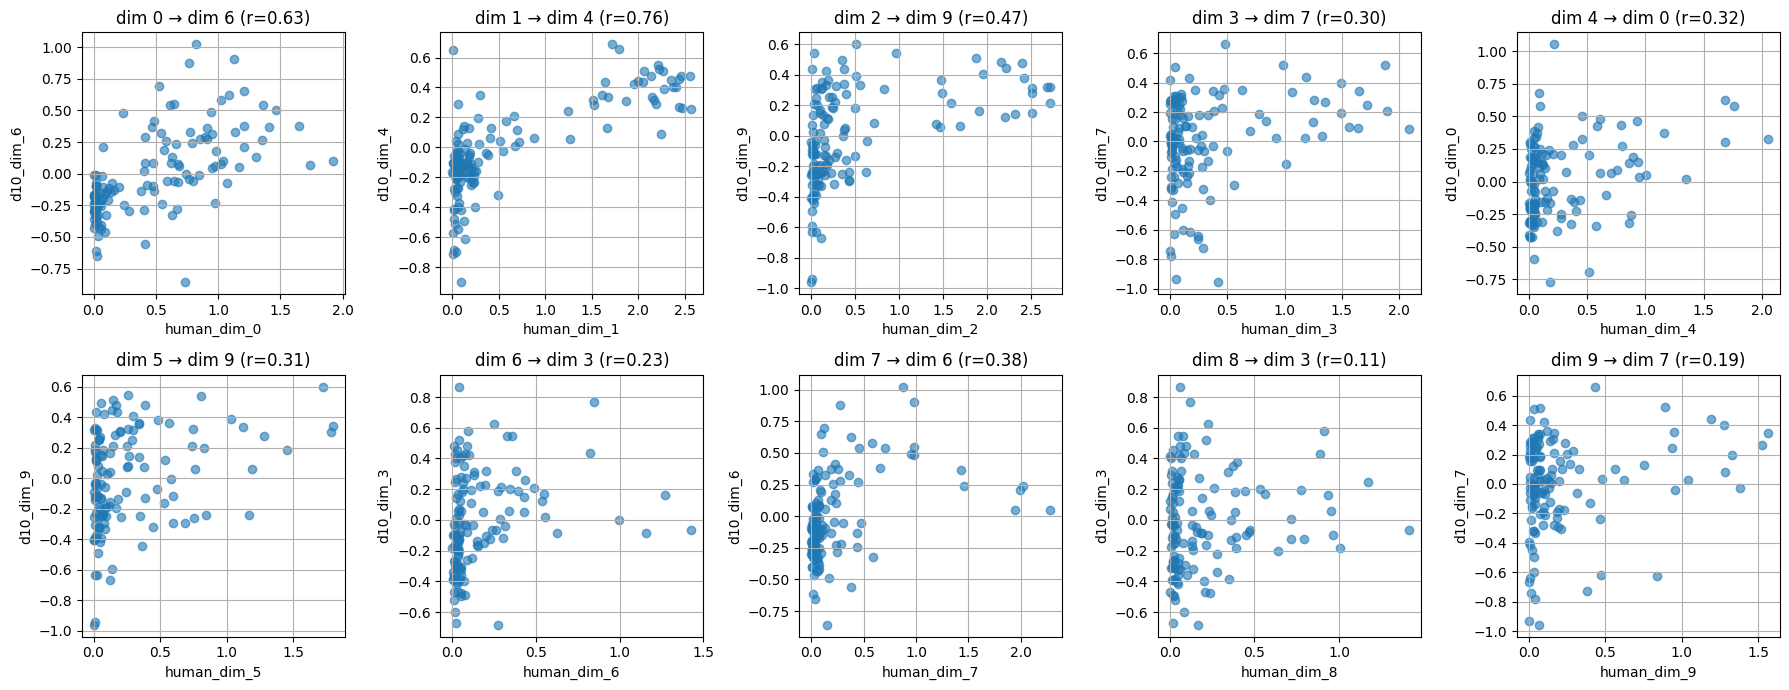

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# --- Subset first 10 dims ---
H10 = subset_dims(embed_human_common, 10)
D10 = subset_dims(embed_d10_common, 10)

# --- Compute correlation matrix ---
corr_matrix = np.corrcoef(H10.values.T, D10.values.T)[:10, 10:]

# --- Find best matching dim for each human dim ---
best_matches = corr_matrix.argmax(axis=1)  # index of best model dim per human dim

fig, axes = plt.subplots(2, 5, figsize=(18, 7))

for i, ax in enumerate(axes.flat):
    j = best_matches[i]
    ax.scatter(H10.iloc[:, i], D10.iloc[:, j], alpha=0.6)
    ax.set_xlabel(f"human_dim_{i}")
    ax.set_ylabel(f"d10_dim_{j}")
    r = corr_matrix[i, j]
    ax.set_title(f"dim {i} → dim {j} (r={r:.2f})")
    ax.grid(True)

plt.tight_layout()
plt.show()


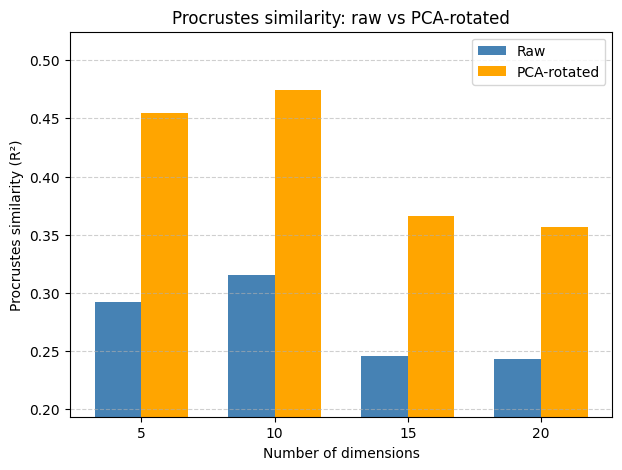

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.linalg import orthogonal_procrustes

# --- Procrustes similarity ---
def procrustes_r2(X, Y):
    R, _ = orthogonal_procrustes(X, Y)
    X_aligned = X @ R
    ssq = np.sum(X_aligned**2)
    return 1 - np.sum((X_aligned - Y)**2) / ssq

# --- Function: compute raw vs PCA-aligned similarity ---
def compare_with_pca(human_df, model_df, n_dims):
    X_h = human_df.filter(like="dim_").iloc[:, :n_dims].values
    X_m = model_df.filter(like="dim_").iloc[:, :n_dims].values

    # Raw Procrustes
    raw = procrustes_r2(X_h, X_m)

    # PCA-rotated Procrustes
    pca_h = PCA(n_components=n_dims).fit_transform(X_h)
    pca_m = PCA(n_components=n_dims).fit_transform(X_m)
    rotated = procrustes_r2(pca_h, pca_m)

    return raw, rotated

# --- Compute both versions ---
results = {}
for n, model_df in [(5, embed_d5_common), (10, embed_d10_common), (15, embed_d15_common), (20, embed_d20_common)]:
    raw, rotated = compare_with_pca(embed_human_common, model_df, n)
    results[n] = {"raw": raw, "rotated": rotated}

# --- Bar plot with side-by-side bars ---
dims = list(results.keys())
raw_vals     = [results[d]["raw"] for d in dims]
rotated_vals = [results[d]["rotated"] for d in dims]

x = np.arange(len(dims))
width = 0.35

plt.figure(figsize=(7,5))
plt.bar(x - width/2, raw_vals, width, label="Raw", color="steelblue")
plt.bar(x + width/2, rotated_vals, width, label="PCA-rotated", color="orange")

plt.xticks(x, [str(d) for d in dims])
plt.xlabel("Number of dimensions")
plt.ylabel("Procrustes similarity (R²)")
plt.title("Procrustes similarity: raw vs PCA-rotated")
plt.ylim(min(raw_vals+rotated_vals) - 0.05, max(raw_vals+rotated_vals) + 0.05)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


In [46]:
import numpy as np
from sklearn.metrics import pairwise_distances
import random

def triplet_agreement(human_df, model_df, n_dims, n_triplets=1000, seed=42):
    rng = np.random.default_rng(seed)

    # align common items
    common = set(human_df["item"]) & set(model_df["item"])
    H = human_df[human_df["item"].isin(common)].set_index("item").sort_index()
    M = model_df[model_df["item"].isin(common)].set_index("item").sort_index()

    # subset dims
    H = H.filter(like="dim_").iloc[:, :n_dims].values
    M = M.filter(like="dim_").iloc[:, :n_dims].values

    items = list(common)
    n_items = len(items)
    correct = 0

    for _ in range(n_triplets):
        # sample triplet
        a, b, c = rng.choice(n_items, size=3, replace=False)

        # distances in human space
        d_ab_h = np.linalg.norm(H[a] - H[b])
        d_ac_h = np.linalg.norm(H[a] - H[c])
        human_choice = b if d_ab_h < d_ac_h else c

        # distances in model space
        d_ab_m = np.linalg.norm(M[a] - M[b])
        d_ac_m = np.linalg.norm(M[a] - M[c])
        model_choice = b if d_ab_m < d_ac_m else c

        if human_choice == model_choice:
            correct += 1

    return correct / n_triplets

# --- Run for each model ---
scores = {
    5:  triplet_agreement(embed_human, embed_d5, 5),
    10: triplet_agreement(embed_human, embed_d10, 10),
    15: triplet_agreement(embed_human, embed_d15, 15),
    20: triplet_agreement(embed_human, embed_d20, 20),
}

print("Triplet agreement scores:", scores)


Triplet agreement scores: {5: 0.628, 10: 0.649, 15: 0.663, 20: 0.667}


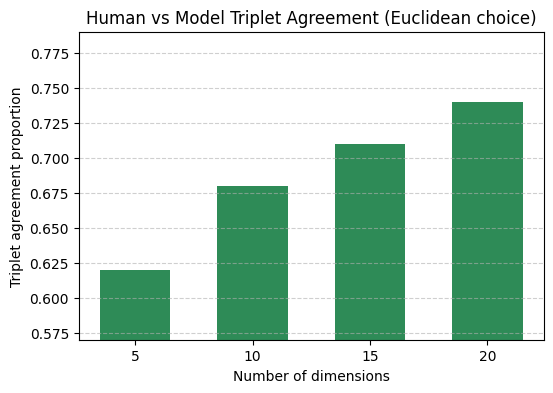

In [47]:
import matplotlib.pyplot as plt

# --- Scores dictionary from triplet_agreement ---
# (replace with your computed values)
scores = {
    5:  0.62,   # example
    10: 0.68,
    15: 0.71,
    20: 0.74,
}

# --- Bar plot ---
dims = list(scores.keys())
vals = list(scores.values())

plt.figure(figsize=(6,4))
plt.bar(dims, vals, width=3, color="seagreen")

plt.xticks(dims, [str(d) for d in dims])  # discrete labels
plt.xlabel("Number of dimensions")
plt.ylabel("Triplet agreement proportion")
plt.title("Human vs Model Triplet Agreement (Euclidean choice)")
plt.ylim(min(vals) - 0.05, max(vals) + 0.05)  # zoom around bar range
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


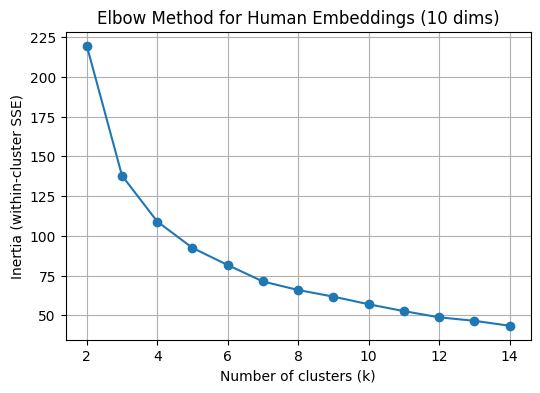

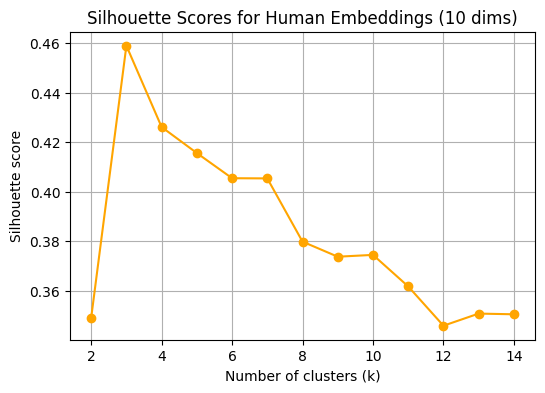

Optimal k (silhouette): 3


In [48]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- Subset first 10 dims of human embeddings ---
H10 = subset_dims(embed_human_common, 10).values

# --- Search for optimal k ---
inertias = []
sil_scores = []
K_range = range(2, 15)  # test between 2 and 14 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(H10)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(H10, labels))

# --- Plot elbow (inertia) ---
plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("Elbow Method for Human Embeddings (10 dims)")
plt.grid(True)
plt.show()

# --- Plot silhouette scores ---
plt.figure(figsize=(6,4))
plt.plot(K_range, sil_scores, marker="o", color="orange")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette Scores for Human Embeddings (10 dims)")
plt.grid(True)
plt.show()

# --- Choose best k (max silhouette score) ---
best_k = K_range[np.argmax(sil_scores)]
print("Optimal k (silhouette):", best_k)

# --- Final KMeans with best k ---
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_final = kmeans_final.fit_predict(H10)


In [49]:
# --- Add cluster labels back to human embeddings ---
embed_human_clusters = embed_human_common.copy()
embed_human_clusters["cluster"] = labels_final

# --- Print items grouped by cluster ---
for c in sorted(embed_human_clusters["cluster"].unique()):
    items = embed_human_clusters[embed_human_clusters["cluster"] == c].index.tolist()
    print(f"\nCluster {c} ({len(items)} items):")
    print(", ".join(items[:30]))  # print first 30 items (truncate if many)



Cluster 0 (73 items):
airbag, album, backscratcher, bag, banjo, baseball, baseball glove, bassinet, bassoon, bathrobe, bathtub, beachball, beanbag, beanie, bed, bench, blower, bongo, bow, bracelet, button, cannonball, canvas, carriage, chainsaw, chaps, coaster, computer screen, cooker, cot

Cluster 1 (32 items):
appetizer, applesauce, baklava, beer, bok choy, bread, crepe, cupcake, dessert, dough, enchilada, gourd, grapefruit, gravy, honeypot, hummus, leek, mango, margarita, mashed potato, milkshake, oatmeal, parfait, pumpkin, quesadilla, quiche, ravioli, souffle, stew, tortellini

Cluster 2 (23 items):
badger, bear, butterfly, chipmunk, cow, crow, fishbowl, flower, fly, giraffe, grasshopper, hyena, iguana, lion, mosquito, mouse, owl, parrot, puffin, sea urchin, snail, snake, tarantula


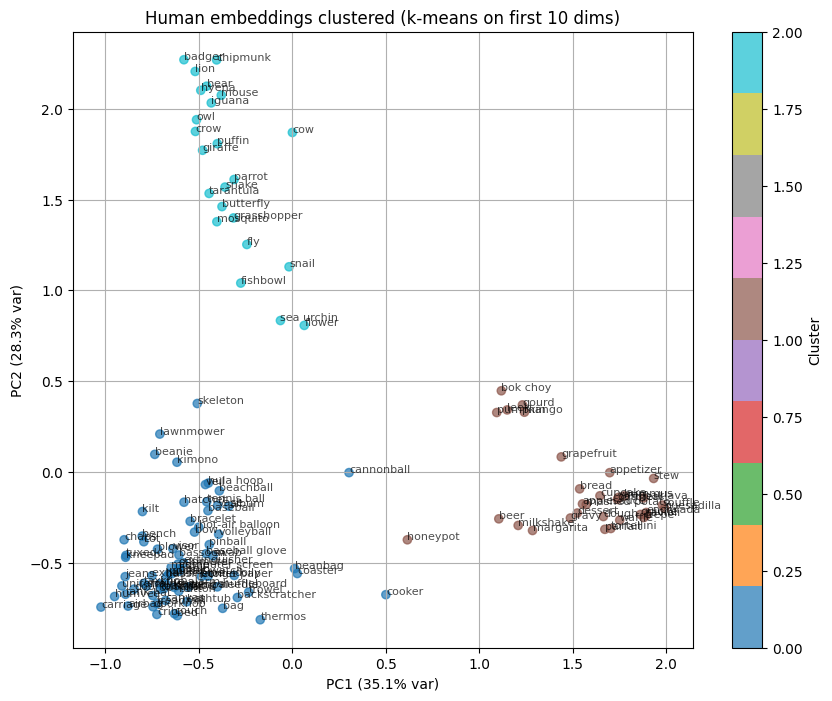

In [50]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- PCA to 2D for visualization ---
H10 = subset_dims(embed_human_common, 10).values
pca = PCA(n_components=2)
H2d = pca.fit_transform(H10)

# --- DataFrame with cluster assignments ---
plot_df = embed_human_common.copy()
plot_df["cluster"] = labels_final
plot_df["PC1"] = H2d[:, 0]
plot_df["PC2"] = H2d[:, 1]

# --- Plot ---
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    plot_df["PC1"], plot_df["PC2"], 
    c=plot_df["cluster"], cmap="tab10", alpha=0.7
)

# add labels
for i, txt in enumerate(plot_df.index):
    plt.annotate(txt, (plot_df["PC1"].iloc[i], plot_df["PC2"].iloc[i]), 
                 fontsize=8, alpha=0.7)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("Human embeddings clustered (k-means on first 10 dims)")
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.show()


Optimal k for D10 model: 4


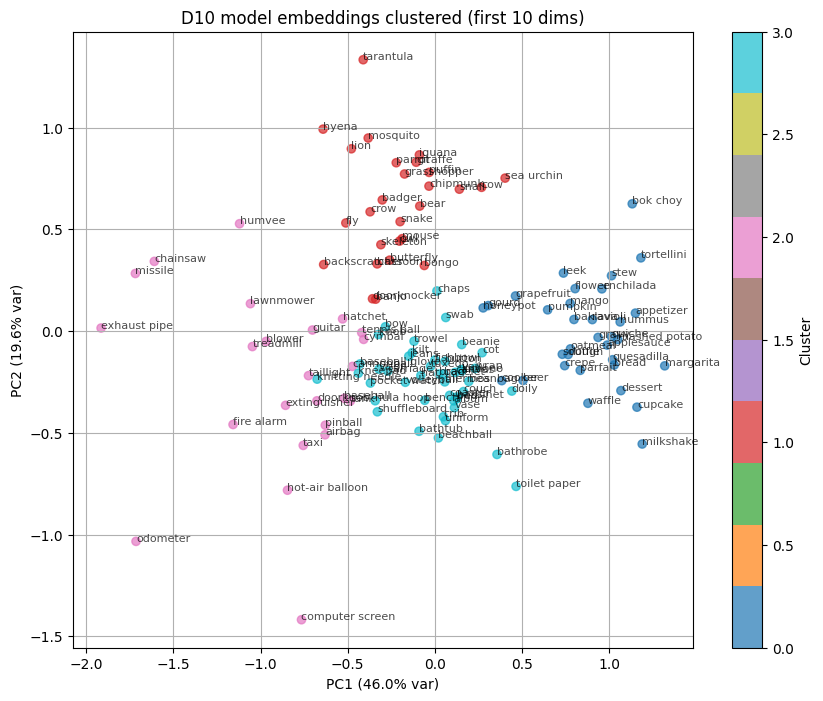

In [51]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# --- Subset first 10 dims of d10 ---
D10 = subset_dims(embed_d10_common, 10).values

# --- Search for optimal k ---
inertias = []
sil_scores = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(D10)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(D10, labels))

# --- Choose best k (max silhouette) ---
best_k_d10 = K_range[np.argmax(sil_scores)]
print("Optimal k for D10 model:", best_k_d10)

# --- Final clustering ---
kmeans_d10 = KMeans(n_clusters=best_k_d10, random_state=42, n_init=10)
labels_d10 = kmeans_d10.fit_predict(D10)

# --- Attach labels ---
embed_d10_clusters = embed_d10_common.copy()
embed_d10_clusters["cluster"] = labels_d10

# --- PCA for visualization ---
pca_d10 = PCA(n_components=2)
D10_2d = pca_d10.fit_transform(D10)

embed_d10_clusters["PC1"] = D10_2d[:, 0]
embed_d10_clusters["PC2"] = D10_2d[:, 1]

# --- Plot ---
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embed_d10_clusters["PC1"], embed_d10_clusters["PC2"],
    c=embed_d10_clusters["cluster"], cmap="tab10", alpha=0.7
)

for i, txt in enumerate(embed_d10_clusters.index):
    plt.annotate(txt, (embed_d10_clusters["PC1"].iloc[i], embed_d10_clusters["PC2"].iloc[i]),
                 fontsize=8, alpha=0.7)

plt.xlabel(f"PC1 ({pca_d10.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca_d10.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("D10 model embeddings clustered (first 10 dims)")
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.show()


Optimal k for D20 model: 4


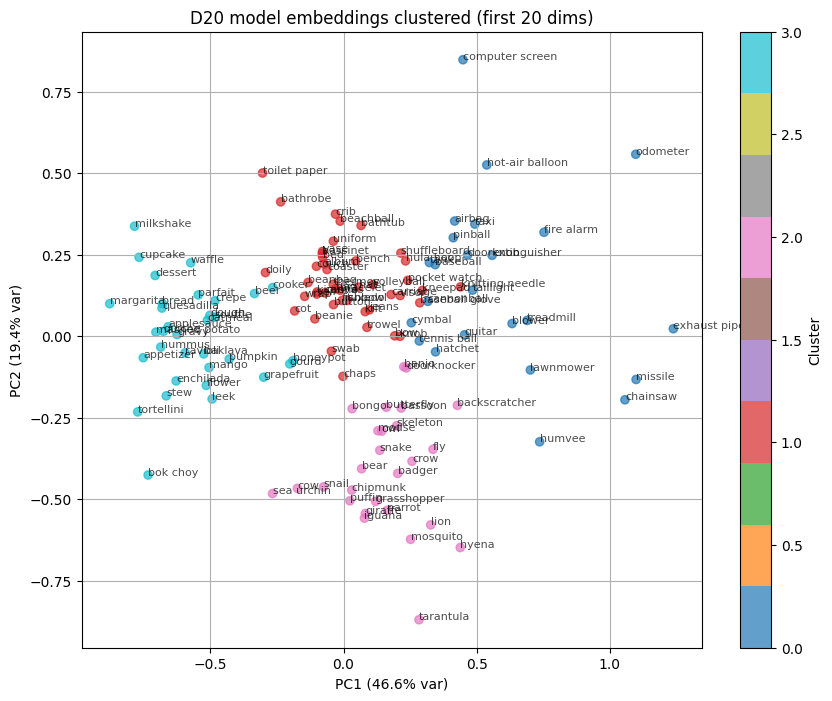

In [52]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# --- Subset first 20 dims of d20 ---
D20 = subset_dims(embed_d20_common, 20).values

# --- Search for optimal k ---
inertias = []
sil_scores = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(D20)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(D20, labels))

# --- Choose best k (max silhouette) ---
best_k_d20 = K_range[np.argmax(sil_scores)]
print("Optimal k for D20 model:", best_k_d20)

# --- Final clustering ---
kmeans_d20 = KMeans(n_clusters=best_k_d20, random_state=42, n_init=10)
labels_d20 = kmeans_d20.fit_predict(D20)

# --- Attach labels ---
embed_d20_clusters = embed_d20_common.copy()
embed_d20_clusters["cluster"] = labels_d20

# --- PCA for visualization ---
pca_d20 = PCA(n_components=2)
D20_2d = pca_d20.fit_transform(D20)

embed_d20_clusters["PC1"] = D20_2d[:, 0]
embed_d20_clusters["PC2"] = D20_2d[:, 1]

# --- Plot ---
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embed_d20_clusters["PC1"], embed_d20_clusters["PC2"],
    c=embed_d20_clusters["cluster"], cmap="tab10", alpha=0.7
)

for i, txt in enumerate(embed_d20_clusters.index):
    plt.annotate(txt, (embed_d20_clusters["PC1"].iloc[i], embed_d20_clusters["PC2"].iloc[i]),
                 fontsize=8, alpha=0.7)

plt.xlabel(f"PC1 ({pca_d20.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca_d20.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("D20 model embeddings clustered (first 20 dims)")
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.show()


Optimal k for Human (20 dims): 3


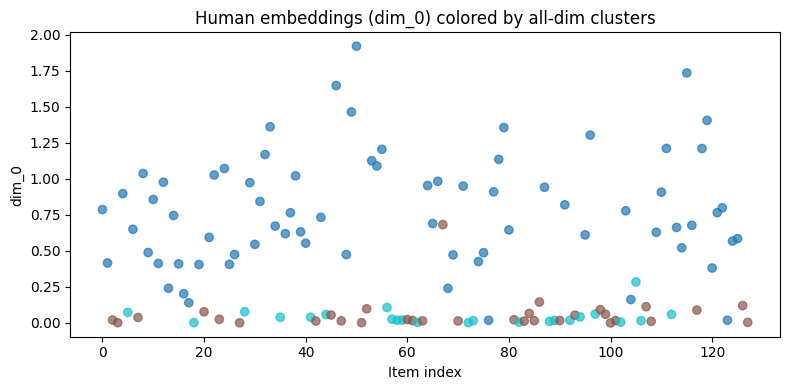

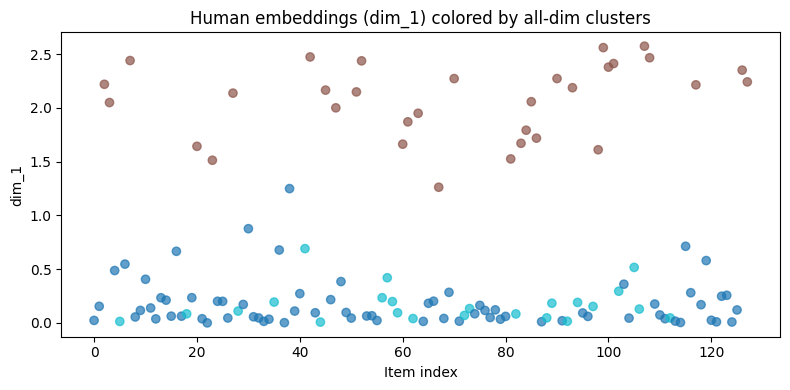

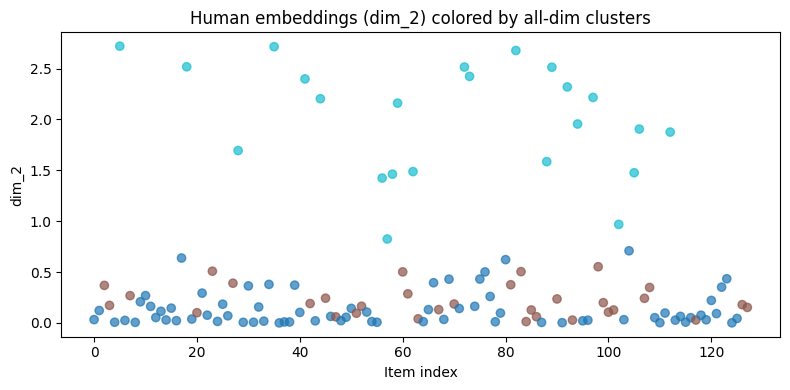

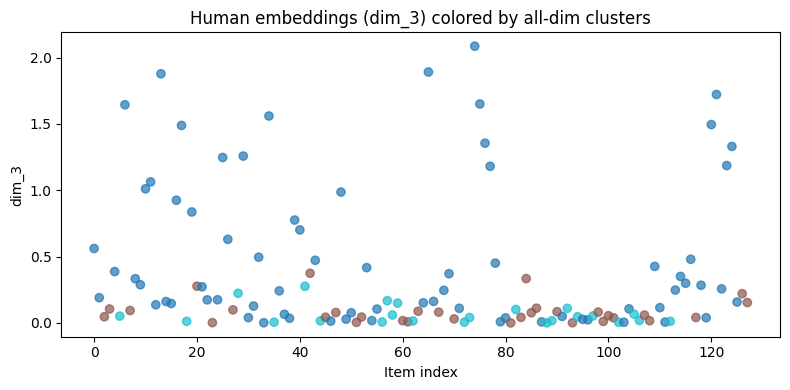

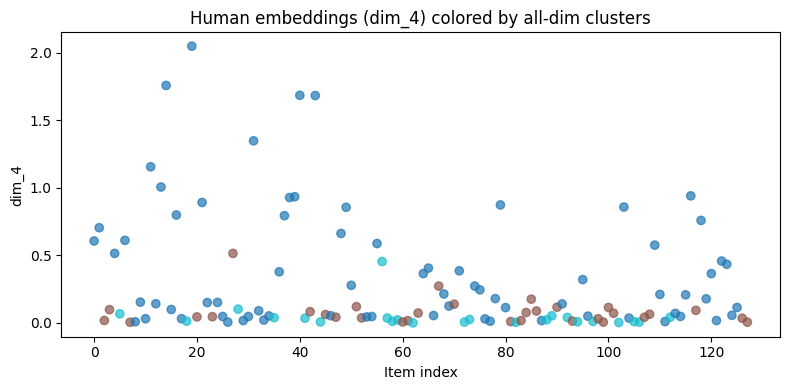

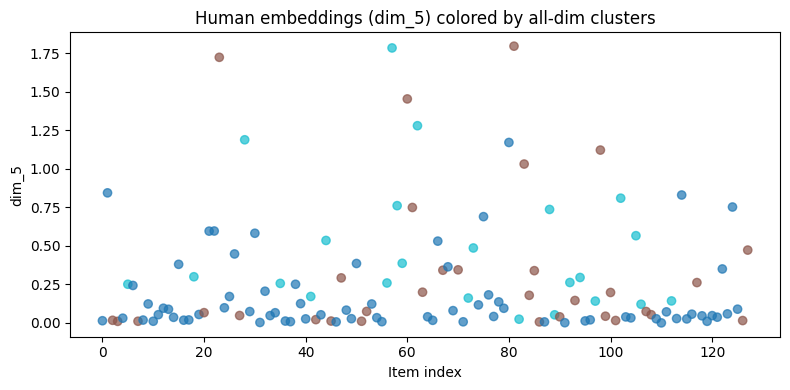

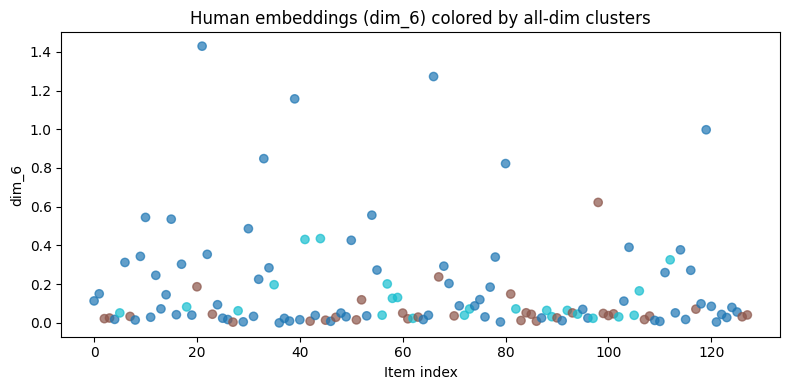

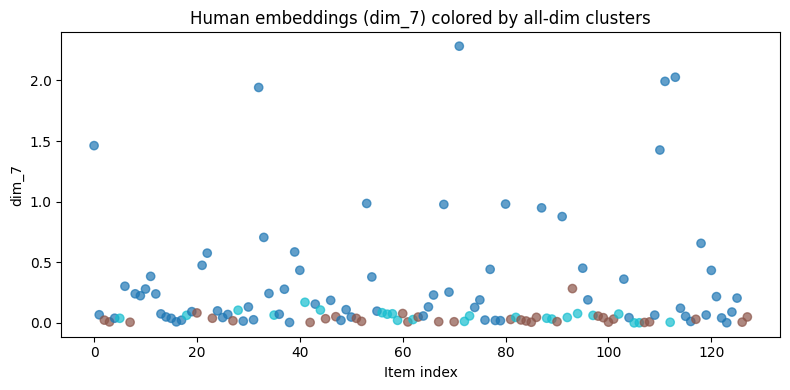

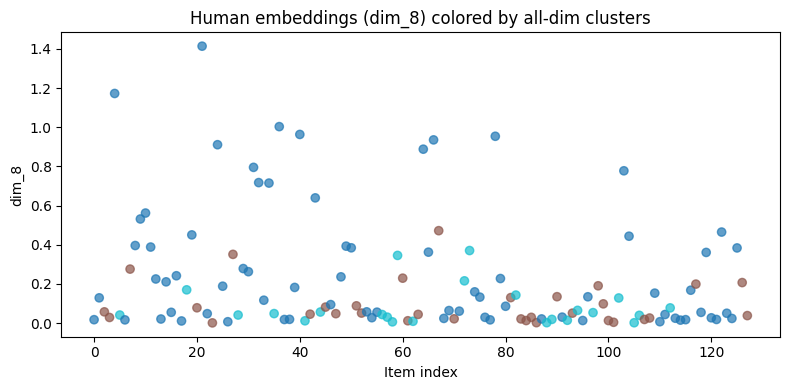

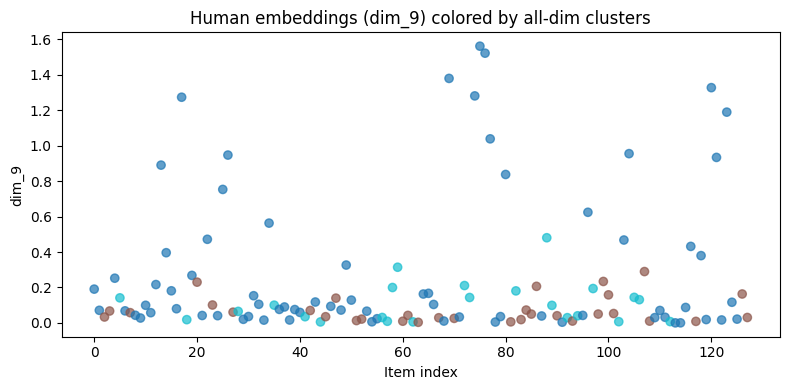

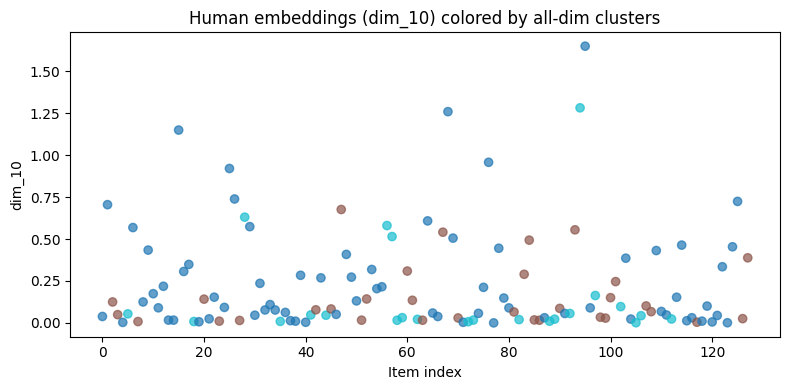

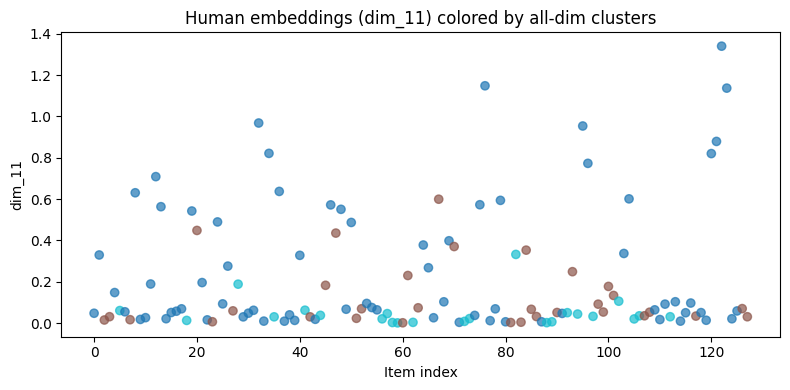

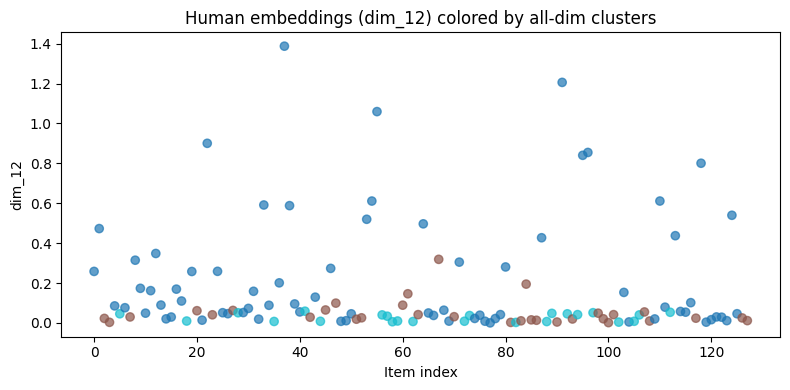

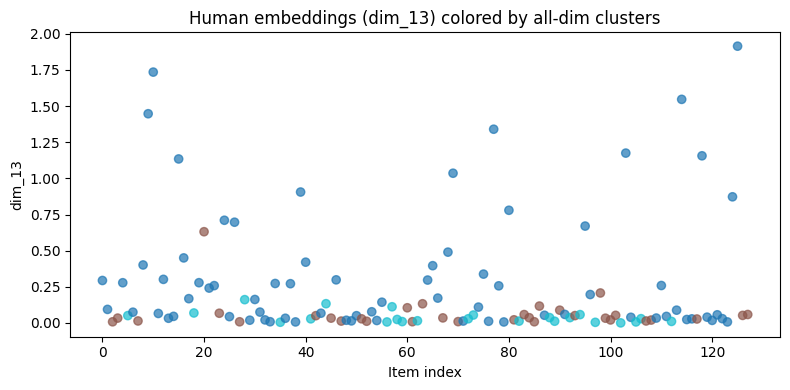

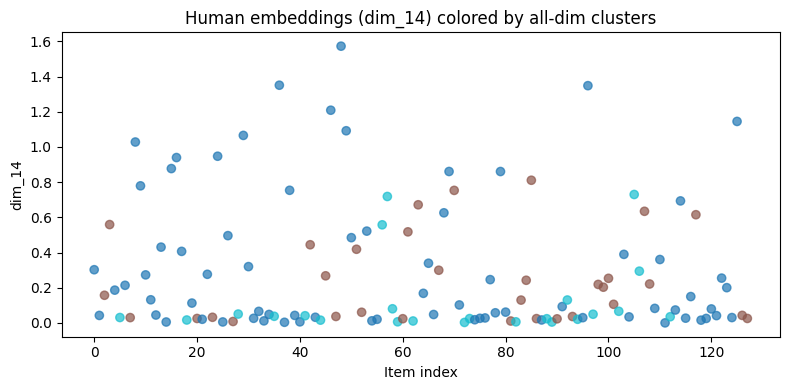

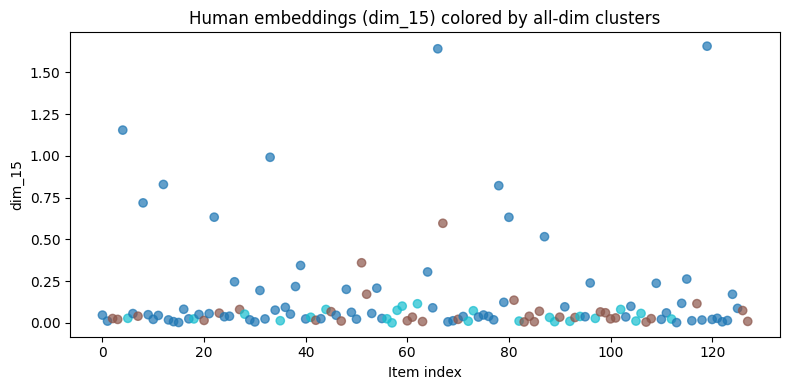

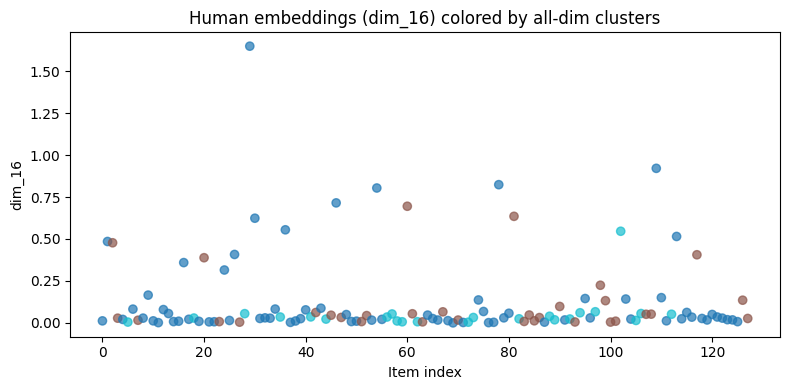

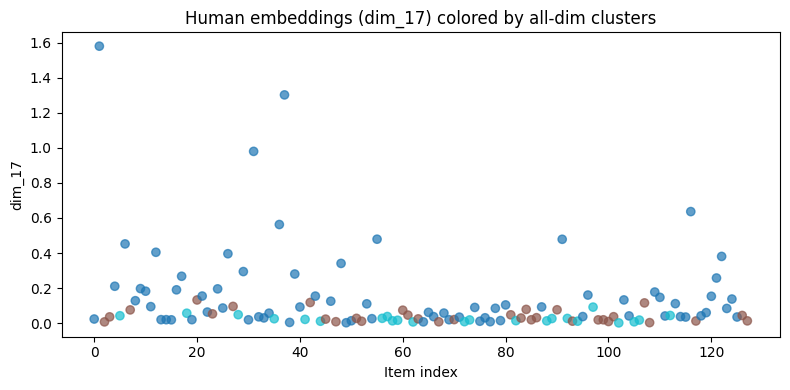

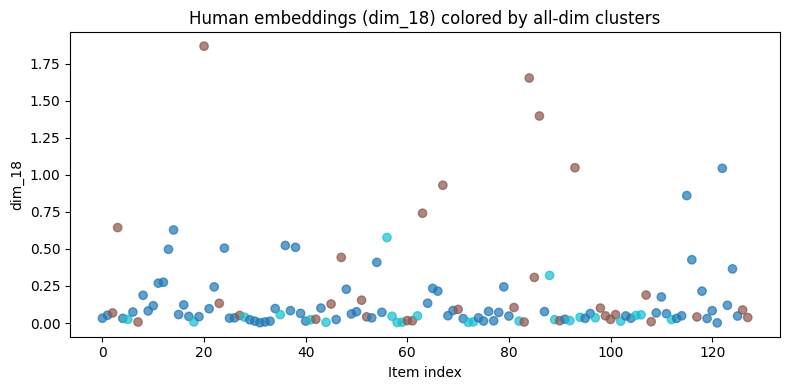

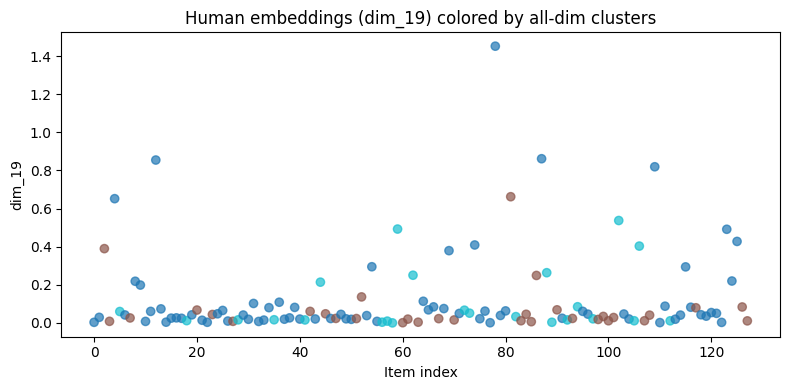

In [54]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# --- Subset first 20 human dims ---
H20 = subset_dims(embed_human_common, 20).values

# --- Search for optimal k ---
sil_scores = []
K_range = range(2, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(H20)
    sil_scores.append(silhouette_score(H20, labels))

best_k_h20 = K_range[np.argmax(sil_scores)]
print("Optimal k for Human (20 dims):", best_k_h20)

# --- Final clustering across all 20 dims ---
kmeans_h20 = KMeans(n_clusters=best_k_h20, random_state=42, n_init=10)
labels_h20 = kmeans_h20.fit_predict(H20)

embed_human_clusters20 = embed_human_common.copy()
embed_human_clusters20["cluster"] = labels_h20

# --- Plot each dimension separately, colored by cluster ---
for i in range(20):
    plt.figure(figsize=(8,4))
    plt.scatter(
        range(len(embed_human_clusters20)),  # item index for spacing
        embed_human_clusters20[f"dim_{i}"],
        c=embed_human_clusters20["cluster"],
        cmap="tab10",
        alpha=0.7
    )
    plt.xlabel("Item index")
    plt.ylabel(f"dim_{i}")
    plt.title(f"Human embeddings (dim_{i}) colored by all-dim clusters")
    plt.tight_layout()
    plt.show()


Optimal k for D10 (10 dims): 4


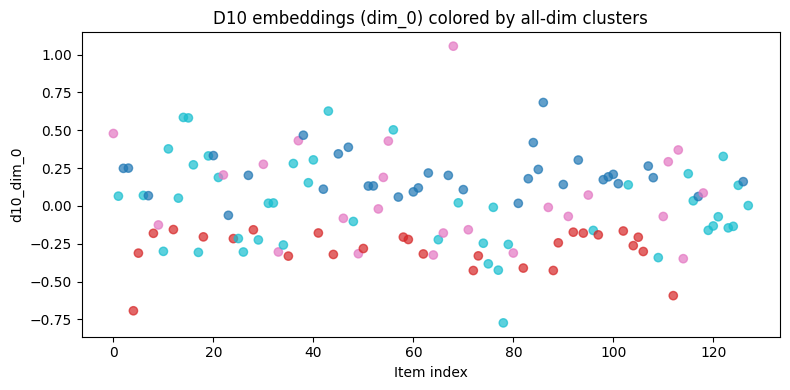

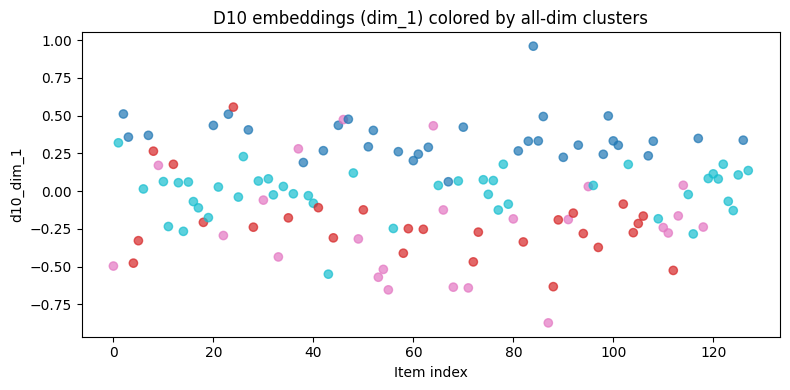

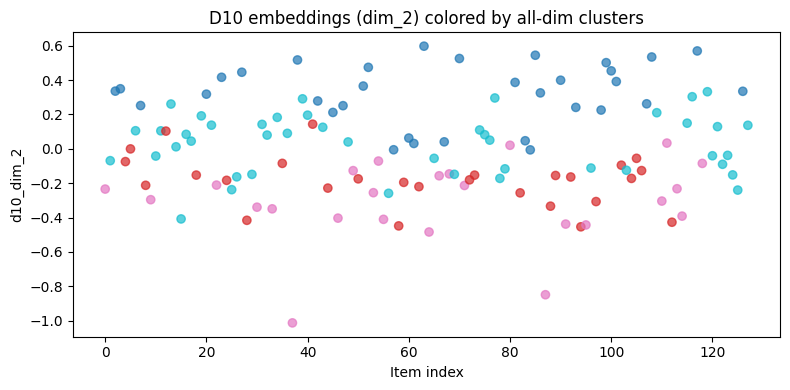

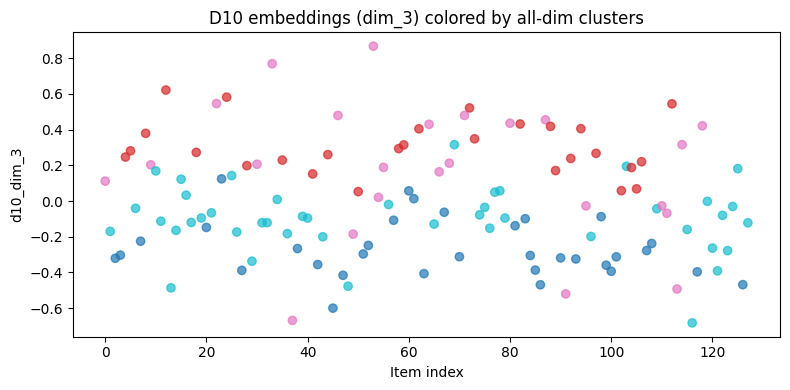

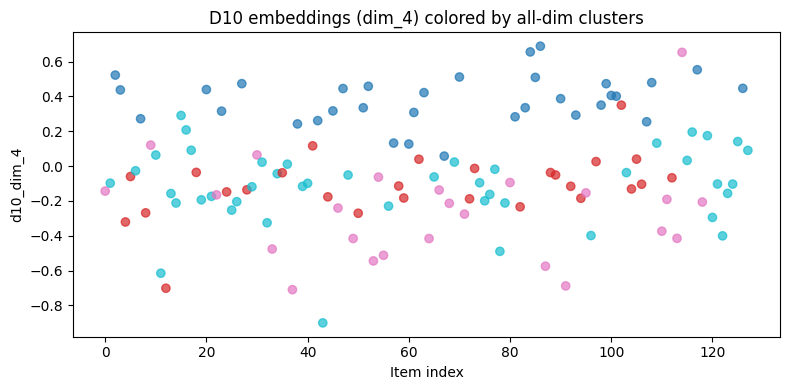

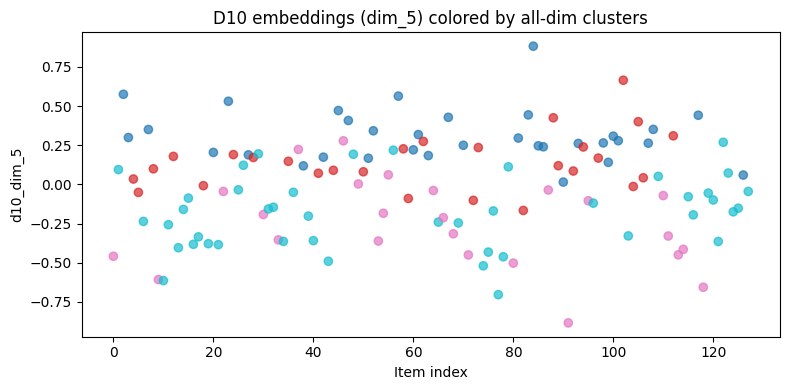

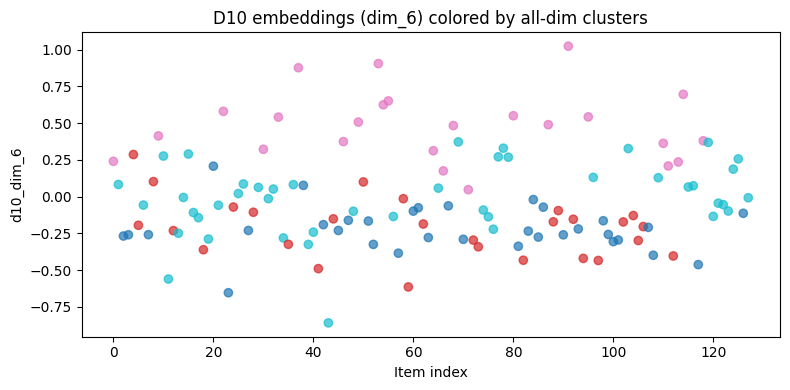

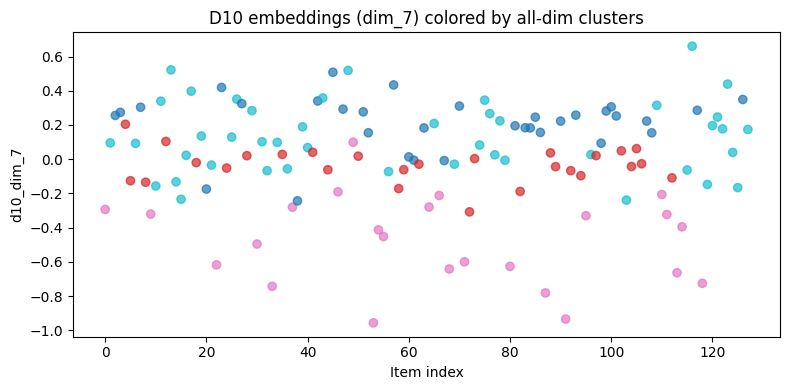

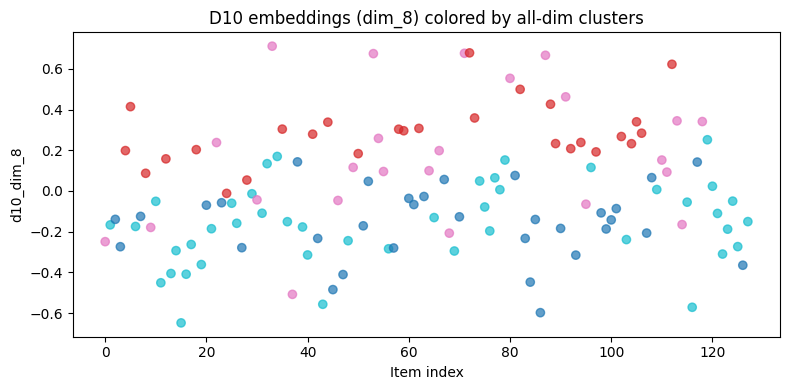

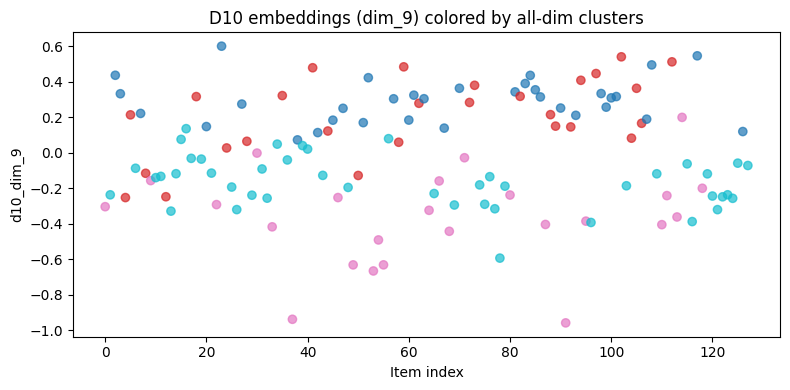

In [55]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# --- Subset first 10 dims of d10 ---
D10 = subset_dims(embed_d10_common, 10).values

# --- Search for optimal k ---
sil_scores = []
K_range = range(2, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(D10)
    sil_scores.append(silhouette_score(D10, labels))

best_k_d10 = K_range[np.argmax(sil_scores)]
print("Optimal k for D10 (10 dims):", best_k_d10)

# --- Final clustering across all 10 dims ---
kmeans_d10 = KMeans(n_clusters=best_k_d10, random_state=42, n_init=10)
labels_d10 = kmeans_d10.fit_predict(D10)

embed_d10_clusters10 = embed_d10_common.copy()
embed_d10_clusters10["cluster"] = labels_d10

# --- Plot each dimension separately, colored by all-dim clusters ---
for i in range(10):
    plt.figure(figsize=(8,4))
    plt.scatter(
        range(len(embed_d10_clusters10)),  # item index
        embed_d10_clusters10[f"dim_{i}"],
        c=embed_d10_clusters10["cluster"],
        cmap="tab10",
        alpha=0.7
    )
    plt.xlabel("Item index")
    plt.ylabel(f"d10_dim_{i}")
    plt.title(f"D10 embeddings (dim_{i}) colored by all-dim clusters")
    plt.tight_layout()
    plt.show()


Rotated Procrustes R² vs d20: {'d5': 0.5406751232128448, 'd10': 0.6777925165090106, 'd15': 0.9563823196052272}


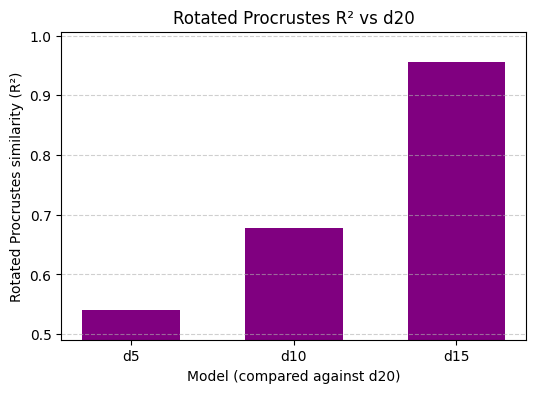

In [56]:
from sklearn.decomposition import PCA
from scipy.linalg import orthogonal_procrustes
import numpy as np
import matplotlib.pyplot as plt

def procrustes_r2(X, Y):
    R, _ = orthogonal_procrustes(X, Y)
    X_aligned = X @ R
    ssq = np.sum(X_aligned**2)
    return 1 - np.sum((X_aligned - Y)**2) / ssq

def rotated_procrustes(df1, df2, n_dims):
    X1 = df1.filter(like="dim_").iloc[:, :n_dims].values
    X2 = df2.filter(like="dim_").iloc[:, :n_dims].values
    # PCA rotate both spaces
    X1_rot = PCA(n_components=n_dims).fit_transform(X1)
    X2_rot = PCA(n_components=n_dims).fit_transform(X2)
    return procrustes_r2(X1_rot, X2_rot)

# --- Compute rotated Procrustes R² against d20 ---
scores = {
    "d5":  rotated_procrustes(embed_d5_common, embed_d20_common, 5),
    "d10": rotated_procrustes(embed_d10_common, embed_d20_common, 10),
    "d15": rotated_procrustes(embed_d15_common, embed_d20_common, 15),
}

print("Rotated Procrustes R² vs d20:", scores)

# --- Bar plot ---
plt.figure(figsize=(6,4))
plt.bar(scores.keys(), scores.values(), color="purple", width=0.6)

plt.xlabel("Model (compared against d20)")
plt.ylabel("Rotated Procrustes similarity (R²)")
plt.title("Rotated Procrustes R² vs d20")
plt.ylim(min(scores.values()) - 0.05, max(scores.values()) + 0.05)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()
